# <center>Effective Approaches to Attention-based Neural Machine Translation</center>
<center> <strong> Submitted By : Aniruddha P. Deshpande (20161058) </strong> </center>
<center> <strong> Reference : </strong>
<a href="https://github.com/ShichaoJin/Neural-Machine-Translation" title="Neural Machine Translation implemented in PyTorch">Neural Machine Translation implemented in PyTorch</a>  </center>

### 1. Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import random
import torch.optim as optim
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import re
import time
import unicodedata

### 2. Helper Functions for Preprocessing

In [2]:
def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))


def validate_language_params(l):
    is_missing = (not os.path.exists('../data/attention_params_{}'.format(l))
                  or not os.path.exists('../data/decoder_params_{}'.format(l))
                  or not os.path.exists('../data/encoder_params_{}'.format(l)))

    if is_missing:
        print("Model params for language '{}' do not exist in the data directory. Please train a new model for this language.".format(l))
        exit(1)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

### 3. Language Class

In [3]:
class Language:
    sos_token = 0
    eos_token = 1

    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: '<SOS>', 1: '<EOS>', '<UNK>': 2}
        self.n_words = len(self.index2word)

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### 4. Reading Data

In [4]:
max_length = 20

# Data Extraction

def filter_pair(p):
    is_good_length = len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length
    return is_good_length


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]


def prepare_data():

    # Read and filter sentences
    input_lang, output_lang, pairs = read_languages()
    pairs = filter_pairs(pairs)

    # Index words
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs


def read_languages():

    # Read and parse the text file
    doc_eng = open('../../Data/enghin/train.en', encoding='utf-8').read()
    doc_hin = open('../../Data/enghin/train.hi', encoding='utf-8').read()
    lines_eng = doc_eng.strip().split('\n')
    lines_hin = doc_hin.strip().split('\n')

    # Transform the data and initialize language instances
    pairs = []
    for i in range(0,len(lines_eng)):
        curr_pair = [normalize_string(lines_eng[i]), lines_hin[i]]
        pairs.append(curr_pair)
    
    input_lang = Language('eng')
    output_lang = Language('hin')

    return input_lang, output_lang, pairs


#Data Transformation


# Returns a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(1)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
    var = var.cuda()
    return var


def variables_from_pair(pair, input_lang, output_lang):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return input_variable, target_variable

### 5. Global Attention Model

In [5]:
class Attention(nn.Module):
    """Attention nn module that is responsible for computing the alignment scores."""

    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        # Define layers
        if self.method == 'general':
            self.attention = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))

    def forward(self, hidden, encoder_outputs):
        """Attend all encoder inputs conditioned on the previous hidden state of the decoder.
        
        After creating variables to store the attention energies, calculate their 
        values for each encoder output and return the normalized values.
        
        Args:
            hidden: decoder hidden output used for condition
            encoder_outputs: list of encoder outputs
            
        Returns:
             Normalized (0..1) energy values, re-sized to 1 x 1 x seq_len
        """

        seq_len = len(encoder_outputs)
        energies = Variable(torch.zeros(seq_len)).cuda()
        for i in range(seq_len):
            energies[i] = self._score(hidden, encoder_outputs[i])
        return F.softmax(energies).unsqueeze(0).unsqueeze(0)

    def _score(self, hidden, encoder_output):
        """Calculate the relevance of a particular encoder output in respect to the decoder hidden."""

        if self.method == 'dot':
            energy = torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attention(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attention(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.other.view(-1), energy.view(-1))
        return energy

### 6. Encoder Model

In [6]:
class EncoderRNN(nn.Module):
    """Recurrent neural network that encodes a given input sequence."""

    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

    def forward(self, word_inputs, hidden):
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        hidden = hidden.cuda()
        return hidden

### 7. Decoder Model

In [7]:
class AttentionDecoderRNN(nn.Module):
    """Recurrent neural network that makes use of gated recurrent units to translate encoded inputs using attention."""

    def __init__(self, attention_model, hidden_size, output_size, n_layers=1, dropout_p=.1):
        super(AttentionDecoderRNN, self).__init__()
        self.attention_model = attention_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)

        # Choose attention model
        if attention_model is not None:
            self.attention = Attention(attention_model, hidden_size)

    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        """Run forward propagation one step at a time.
        
        Get the embedding of the current input word (last output word) [s = 1 x batch_size x seq_len]
        then combine them with the previous context. Use this as input and run through the RNN. Next,
        calculate the attention from the current RNN state and all encoder outputs. The final output
        is the next word prediction using the RNN hidden state and context vector.
        
        Args:
            word_input: torch Variable representing the word input constituent
            last_context: torch Variable representing the previous context
            last_hidden: torch Variable representing the previous hidden state output
            encoder_outputs: torch Variable containing the encoder output values
            
        Return:
            output: torch Variable representing the predicted word constituent 
            context: torch Variable representing the context value
            hidden: torch Variable representing the hidden state of the RNN
            attention_weights: torch Variable retrieved from the attention model
        """

        # Run through RNN
        word_embedded = self.embedding(word_input).view(1, 1, -1)
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention
        attention_weights = self.attention(rnn_output.squeeze(0), encoder_outputs)
        context = attention_weights.bmm(encoder_outputs.transpose(0, 1))

        # Predict output
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        return output, context, hidden, attention_weights

### 8. Training

#### 8.1 Train Function

In [8]:
teacher_forcing_ratio = .5
clip = 5.


def train(input_var, target_var, encoder, decoder, encoder_opt, decoder_opt, criterion):
    # Initialize optimizers and loss
    encoder_opt.zero_grad()
    decoder_opt.zero_grad()
    loss = 0

    # Get input and target seq lengths
    target_length = target_var.size()[0]

    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_var, encoder_hidden)

    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([0]))
    decoder_input = decoder_input.cuda()
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_context = decoder_context.cuda()
    decoder_hidden = encoder_hidden

    # Scheduled sampling
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        # Feed target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                                         decoder_context,
                                                                                         decoder_hidden,
                                                                                         encoder_outputs)
            loss += criterion(decoder_output, target_var[di])
            decoder_input = target_var[di]
    else:
        # Use previous prediction as next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input,
                                                                                         decoder_context,
                                                                                         decoder_hidden,
                                                                                         encoder_outputs)
            loss += criterion(decoder_output, target_var[di])

            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda()

            if ni == 1:
                break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_opt.step()
    decoder_opt.step()
    
    return loss.data / target_length

#### 8.2 Running Training Epochs

In [9]:
input_lang, output_lang, pairs = prepare_data()

attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttentionDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
encoder.cuda()
decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

# Configuring training
n_epochs = 100000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

# Begin training
for epoch in range(1, n_epochs + 1):

    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs), input_lang, output_lang)
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train step
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0:
        continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_time = time_since(start, epoch / n_epochs)
        print('%s (%d %d%%) %.4f' % (print_time, epoch, epoch / n_epochs * 100, print_loss_avg))

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0


/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:56: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:57: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


6m 50s (- 677m 23s) (1000 1%) 6.0246
13m 9s (- 645m 0s) (2000 2%) 5.9256
19m 58s (- 646m 1s) (3000 3%) 5.8807
26m 31s (- 636m 26s) (4000 4%) 5.7545
35m 18s (- 670m 44s) (5000 5%) 5.8105
44m 7s (- 691m 24s) (6000 6%) 5.7838
51m 49s (- 688m 32s) (7000 7%) 5.6374
59m 40s (- 686m 14s) (8000 8%) 5.6474
68m 2s (- 687m 55s) (9000 9%) 5.5283
77m 18s (- 695m 42s) (10000 10%) 5.6007
87m 38s (- 709m 5s) (11000 11%) 5.5420
98m 53s (- 725m 15s) (12000 12%) 5.5947
109m 32s (- 733m 5s) (13000 13%) 5.4621
116m 24s (- 715m 2s) (14000 14%) 5.4406
123m 27s (- 699m 34s) (15000 15%) 5.3307
130m 47s (- 686m 38s) (16000 16%) 5.4215
137m 57s (- 673m 31s) (17000 17%) 5.3096
145m 46s (- 664m 3s) (18000 18%) 5.2336
152m 34s (- 650m 26s) (19000 19%) 5.1815
159m 41s (- 638m 45s) (20000 20%) 5.2348
166m 44s (- 627m 16s) (21000 21%) 5.1911
173m 39s (- 615m 41s) (22000 22%) 5.1468
180m 37s (- 604m 42s) (23000 23%) 5.1186
187m 35s (- 594m 1s) (24000 24%) 5.1159
194m 27s (- 583m 22s) (25000 25%) 5.0986
201m 24s (- 573m

#### 8.3 Saving Models

In [10]:
# Save our models
torch.save(encoder.state_dict(), '../../Models/Eff_Attn_NMT/Encoder/eng_to_hin_encoder_params_{}'.format(attn_model))
torch.save(decoder.state_dict(), '../../Models/Eff_Attn_NMT/Decoder/eng_to_hin_decoder_params_{}'.format(attn_model))
torch.save(decoder.attention.state_dict(), '../../Models/Eff_Attn_NMT/Attention/eng_to_hin_attention_params_{}'.format(attn_model))

#### 8.4 Plotting Losses

<Figure size 432x288 with 0 Axes>

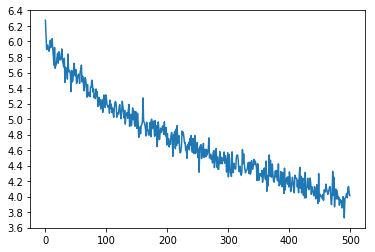

In [11]:
show_plot(plot_losses)

### 9. Evaluation

#### 9.1 Evaluation Function

In [9]:
def evaluate(sentence, max_length=20):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]

    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[Language.sos_token]]))  # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_input = decoder_input.cuda()
    decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context,
                                                                                     decoder_hidden, encoder_outputs)
        decoder_attentions[di, :decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        ni = ni.item()
        if ni == Language.eos_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda()

    return decoded_words, decoder_attentions[:di + 1, :len(encoder_outputs)]

#### 9.2 Evaluating randomly chosen pairs from the training set

In [10]:
def evaluateRandomly(n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### 9.3 Calling above evaluation function

In [14]:
input_lang, output_lang, pairs = prepare_data()
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttentionDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Load model parameters
encoder.load_state_dict(torch.load('../../Models/Eff_Attn_NMT/Encoder/eng_to_hin_encoder_params_{}'.format(attn_model)))
decoder.load_state_dict(torch.load('../../Models/Eff_Attn_NMT/Decoder/eng_to_hin_decoder_params_{}'.format(attn_model)))
decoder.attention.load_state_dict(torch.load('../../Models/Eff_Attn_NMT/Attention/eng_to_hin_attention_params_{}'.format(attn_model)))

# Move models to GPU
encoder.cuda()
decoder.cuda()

evaluateRandomly()

> the uparkot fort of junagarh is especially worth seeing .
= जूनागढ़ का ’ ऊपरकोट ’ किला विशेष रूप से दर्शनीय है ।
< दुर्ग किले का किला किला किला किला किला है । <EOS>

> be it tug of war camel dance or their acrobatics .
= चाहे वह रस्साकसी हो , ऊँटों का नृत्य हो या उनकी कलाबाजियाँ ।
< यह , , , या या या या हो हो हो । । <EOS>

> save the children from dust .
= बच्चे को धूल से बचाएँ ।
< बच्चों को बच्चे से से । । <EOS>

> nearest railway station is kangra temple lrb kms rrb .
= निकटस्थ रेलवे स्टेशन कांगड़ा मंदिर ( 22 कि.मी. ) है ।
< नजदीकी रेलवे स्टेशन - स्टेशन ( कि.मी. कि.मी. ) कि.मी. ) । <EOS>

> in bright sunshine above the roofm of houses a thick layer of snow is sparkling .
= खिली-खिली धूप में घरों की छत के ऊपर बर्फ की मोटी तह चमचमा रही है ।


/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/aniruddha/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


< धूप में द्वारा की में बर्फ की बर्फ की की की की की की की की जाती है । ।

> the feeling of yellow color carpet with the sheen of golden mustard in the spring season appear pleasant .
= बसंत ॠतु में सुनहरी सरसों की आभा से पीतवर्ण गलीचा का अहसास सुखद लगता है ।
< गर्मी के मौसम में में के में का का का का का का । । । <EOS>

> kangchup is a hilly place which is source of mineral oil .
= कांगचुप पहाड़ी स्थान है जो खनिज तेल का स्रोत है ।
< हरियाणा एक जो है जो जो का का का का है है । । <EOS>

> all the animals eat only those things which is available around them .
= प्रकृति प्रत्येक प्राणी को स्वस्थ रखने हेतु अपना पूर्ण सहयोग देती है ।
< सभी ही ही ही ही ही ही ही जो , , ही ही । । <EOS>

> it is estimated that bhagirathji had done his penance here .
= ऐसा अनुमान है , कि भागीरथजी ने यहीं पर तपस्या की थी ।
< किंवदन्ती मान्यता है कि यहाँ ने ने की यहाँ किया किया था । <EOS>

> mainly only two types of mustards are found red and yellow .
= लाल और पीली , मुख्य रूप से दो प्रकार की ही सरसों मिलती है ।
< लाल